In [197]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [198]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # 词汇表大小
    "context_length": 256,  # 上下文长度
    "emb_dim": 768,  # 嵌入维度
    "n_heads": 12,  # 注意力头数
    "n_layers": 12,  #层数
    "drop_rate": 0.1,  # Dropout率
    "qkv_bias": False  # Query-Key-Value偏置
}

In [199]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        #确保是可以被整除的
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        #初始化头的维度、数量
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        #头的输出结合线性层
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        #进行dropout防止过拟合
        self.dropout = nn.Dropout(dropout)
        #上三角掩码
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        # Shape: (b, num_tokens, d_out)
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        #把输出的维度拆成头*头大小
        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        #转制维度,听说是为了更好的计算注意力
        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        # 计算缩放点积注意力
        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        # 将掩码缩减到当前 token 数量，并转换为布尔型
        # 进而实现动态遮蔽,所以不用另开好几个数组
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # 遮蔽矩阵
        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        #归一化
        attn_weights = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)
        #头的合并
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        #对上下文向量的形状进行调整，确保输出的形状
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection
        return context_vec

In [200]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            #这一步把它变得平滑了很多
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [201]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    #运行一次就线性两次激活一次
    def forward(self, x):
        return self.layers(x)

In [202]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [203]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],  # 输入特征维度
            d_out=cfg["emb_dim"],  # 输出特征维度
            context_length=cfg["context_length"],  # 上下文长度
            num_heads=cfg["n_heads"],  # 注意力头的数量
            dropout=cfg["drop_rate"],  # Dropout 比例
            qkv_bias=cfg["qkv_bias"]  # 查询、键和值的偏置
        )  # 多头注意力模块，结合各种参数
        self.ff = FeedForward(cfg)  # 前馈神经网络模块
        self.norm1 = LayerNorm(cfg["emb_dim"])  # 第一归一化层
        self.norm2 = LayerNorm(cfg["emb_dim"])  # 第二归一化层
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])  # 残差连接的 Dropout

    def forward(self, x):
        # 对注意力模块的快捷连接
        shortcut = x
        x = self.norm1(x)  # 应用第一归一化层
        x = self.att(x)  # 通过多头注意力模块，形状为 [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)  # 应用 Dropout
        x = x + shortcut  # 将原始输入加回，实现残差连接

        # 对前馈网络模块的残差连接
        shortcut = x
        x = self.norm2(x)  # 应用第二归一化层
        x = self.ff(x)  # 通过前馈神经网络模块
        x = self.drop_shortcut(x)  # 应用 Dropout
        x = x + shortcut  # 将原始输入加回，实现残差连接

        return x

In [204]:
class GPTModel(nn.Module):  #召唤GPT!
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        #新建字典、位置信息、还有dropout的比率设置
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        #解包操作
        self.trf_blocks = nn.Sequential(
            TransformerBlock(cfg),
            TransformerBlock(cfg),
            TransformerBlock(cfg)
        )
        #归一化
        self.final_norm = LayerNorm(cfg["emb_dim"])
        #输出头保证维度
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [205]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # 预测单词的模块
    # idx 是当前上下文中的（batch, n_tokens）索引数组
    for _ in range(max_new_tokens):
        # 每次生成一个单词后，重新将其加入序列中
        # 如果当前上下文长度超过模型支持的最大上下文长度，则截取
        # 例如，如果LLM只支持5个token，而上下文长度为10
        # 那么只使用最后5个token作为上下文
        idx_cond = idx[:, -context_size:]
        # 如果idx的长度超过模型支持的上下文长度size，只保留最后size个token
        # 避免溢出
        # 获取预测结果
        with torch.no_grad():  # 在推理阶段，不需要计算梯度，因为没有反向传播
            # 这样可以减少存储开销
            logits = model(idx_cond)
            # 模型输出结果
        # 只关注最后一个时间步的输出
        # (batch, n_tokens, vocab_size) 变为 (batch, vocab_size)
        logits = logits[:, -1, :]
        # 关注最后一个时间步
        # 使用softmax函数计算概率
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        # 归一化
        # 获取具有最高概率值的词汇索引
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # 获取概率最高的词汇索引
        # 将采样的索引添加到序列中
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [206]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [207]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor

#给输入的字符进行编码并实现一个Batch维度的向量,符合模型的输入形式
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [208]:
#反向编码,去掉移除张量中的批次维度, 变成普通的链表
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
#举个例子
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    #初始上下文的Token ID张量，是上一步 text_to_token_ids 的输出
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
#输出最长单词度为10的句子
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you margins venconomicia inexperiencedeliwn Exit segregServer


In [209]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
#引入数据集
if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()
#一系列经典的读取数据操作

In [210]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [211]:
class GPTDatasetV1(Dataset):
    #让GPT初始化一个类型
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})  #id是文本内容编码过来的

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [212]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [213]:
#从一个库导入之前的文章
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
#这边可以手动定义训练集跟测试剂的比例

torch.manual_seed(123)
#依旧保持可复现
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
#初始化输入训练模型,给出批处理的大小、给出最大文本容量防止溢出
#给出不畅,丢弃最后一批不足的文本,打开随机防止拟合过度
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)
#验证数据集仅仅修改了是否丢弃跟随抽取

In [214]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [215]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    #呼唤GPU
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    #用交叉熵函数对于logits进行计算并且拉伸到二维长度
    return loss

In [216]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果指定的批次数超过数据加载器中的总批次数，则将批次数减少到与数据加载器的总批次数匹配。
        num_batches = min(num_batches, len(data_loader))
        #减少需要处理的数量,同时也是防止溢出
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
        #一点点加上去的损失
    return total_loss / num_batches

In [217]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 对于 nn.Module 类，不需要赋值 model = model.to(device)
model.to(device)

# 固定随机种子，保证数据加载器打乱数据的结果可复现
torch.manual_seed(123)

# 禁用梯度跟踪以提高效率，因为此时尚未开始训练
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

# 推理阶段不计算梯度
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.975253211127388
Validation loss: 10.943093299865723


In [218]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    #初始化训练模型而且给了空的队列
    # Main training loop
    for epoch in range(num_epochs):  #训练次数
        model.train()  # Set model to training mode
        #转移到训练模块
        #从loader里面调出输入跟目标
        for input_batch, target_batch in train_loader:
            #清空所有函数的梯度
            optimizer.zero_grad()
            #计算损失函数
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            #反向传播优化
            loss.backward()
            #更新权重
            optimizer.step()
            #加一下一共有多少
            tokens_seen += input_batch.numel()
            #看一下一共训练了多少步
            global_step += 1
            # Optional evaluation step
            if global_step % eval_freq == 0:
                #按照一定的步数进行记录
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                #计算损失函数
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                #加到list中
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


#评价模块
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    #检验模式
    model.eval()
    #我认为的双保险,防止梯度更新
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    #在评估结束后切换回训练模式，确保模型能继续用于训练。
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [219]:
# Note:
# Uncomment the following code to calculate the execution time
#下面可以看一下计算了多久
# import time
# start_time = time.time()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
#经典操作
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
#用Adam进行优化,其中学习rate为0.004,动量衰减是0.1
num_epochs = 10
#10论学习
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.518, Val loss 10.599
Ep 1 (Step 000005): Train loss 8.335, Val loss 8.532
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the                          
Ep 2 (Step 000010): Train loss 6.828, Val loss 7.243
Ep 2 (Step 000015): Train loss 6.165, Val loss 6.687
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Step 000020): Train loss 5.905, Val loss 6.603
Ep 3 (Step 000025): Train loss 5.660, Val loss 6.551
Every effort moves you, and, and, and, and, and, and, the, and,, and,, and, and, the, and, the, and, and, and, the, and, the, and, and, and, the
Ep 4 (Step 000030): Train loss 5.072, Val loss 6.444
Ep 4 (Step 000035): Train loss 4.654, Val loss 6.237
Every effort moves you?"       "I the fact. Gisburn. Gisburn's--and I had been. Gisburn's and I had to the fact--and I had the fact, and I had to the his
Ep 5 (Step 000040): Train loss 4.136, Val loss 6.151
Ever

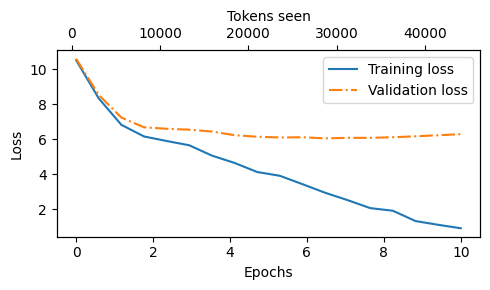

In [220]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
#一个经典的plot画图函数